In [45]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier 
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures   
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# Return pandas DataFrames instead of numpy arrays
# from sklearn import set_config
# set_config(transform_output="pandas")

Gold              = 1.618                          # nothing to do with the group from the 80's
Width             = 12
Height            = Width/Gold
WidthPx           = 1024
HeightPx          = WidthPx/Gold

k_result_file       = "models-benchmark"
k_target            = "converted"
k_header            = "conversion_data_test_predictions_"
k_author            = "PHILIPPE"
k_random_state      = 42            # I know you know ...
k_final_test_size   = 20/100        # typic. 20% from the set of the intial observations is set aside for final testing (unseen data)
k_test_size         = 20/100        # typic. 20% of the remaining 80% of the initial observation ui used for the test_set (we should say validation_set)
k_samples_ratio     = 10/100        # percentage of observation to be taken into account. Pass 100/100 for final testing 
k_verbose           = True         # Enable/disable messages
k_bPrePrepocessing  = False         # this flag indicates to do pre-preprocessing or not



### TODO & IDEAS

#### TODO
* ~~Pie chart pour illustrer le % de dupliqués~~
    * ~~Justifier la méthode de suppression de dupliqués~~
* ~~Vérifier si les distributions sont normales ou skew => 3 sigma ou 1.5 IQR~~
* Use set_config(transform_output="pandas")
* Reorganize code adding a python module 
  * this would help to read the notebook
* add a validation set and make sur to test the mode on unseen data before publication
* see how to transform "preprocessing on df" as a pre processing step
* see how to chain multiple pre processing
* see if it make sense to create a pre processing phase
* fix the vocabulary : 
  * Phase, step... 
  * A phase concists of one or more steps
  * Phase and step are ordered
* review variables names
* ~~Classe déséquilibrées? - SMOTE - Synthetic Minority Oversampling Technique~~
* ~~Bar graph to illustrate 3% and unbalanced classes~~
* ~~can we re run the baseline example on one feature ?~~
  * ~~Yes. See ``Baseline`` selection id ~~
* ~~add graphs in EDA~~
* ~~split the dataset in 3 : train, test and final_test (unseen)~~
* ~~change organization in features engineering~~
* ~~verbosity~~
* ~~<span style="color:red"><b>BUG</b></span> : le dernier fichier de pred est vide ????~~
    * ~~warning at the very end~~

#### IDEAS
* Remove duplicate ?
* Remove outliers ?
* Lasso for feature selection
* ~~support for features engineering~~
* ~~support polyfeatures? Yes~~
* ~~test on one feature. Yes. See Baseline~~
* ~~Support for random forest. Yes~~
* ~~Support for feature selection. Yes~~
* ~~Any co linearity in features ?~~
  * ~~To be added in EDA~~
  * ~~Done with correlation heatmap~~ 
* ~~Are the distributions normal ?~~
  * ~~if needed log or boxCox~~
  * ~~See EDA~~




<!-- 

<span style="color:red"><b>BUG</b></span> : le dernier fichier de pred est vide ????

import ctypes   
ctypes.windll.user32.MessageBoxW(0, "Your text", "Your title", 1)

 -->

## Get the data

In [46]:
df = pd.read_csv('./assets/conversion_data_train.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## Quick EDA

In [47]:
print(f"Shape : {df.shape}")
print()

display(df.describe(include="all").T)


Shape : (284580, 6)



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,284580,4,US,160124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,284580.0,NaN,NaN,NaN,30.564203,8.266789,17.0,24.0,30.0,36.0,123.0
new_user,284580.0,NaN,NaN,NaN,0.685452,0.464336,0.0,0.0,1.0,1.0,1.0
source,284580,3,Seo,139477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_pages_visited,284580.0,NaN,NaN,NaN,4.873252,3.341995,1.0,2.0,4.0,7.0,29.0
converted,284580.0,NaN,NaN,NaN,0.032258,0.176685,0.0,0.0,0.0,0.0,1.0


In [48]:
nb_converted      = df["converted"].sum()
nb_not_converted  = len(df)-nb_converted

print(f"Nb converted               : {nb_converted:>7_}")
print(f"Nb not converted           : {nb_not_converted:>7_}")
percent_converted = (100*nb_converted/(nb_converted+nb_not_converted)).round(2)
print(f"Nb converted as % of total : {percent_converted:>7_} %")

Nb converted               :   9_180
Nb not converted           : 275_400
Nb converted as % of total :    3.23 %


C:\Users\phili\AppData\Local\Temp\ipykernel_19756\675469837.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot (x=categories, y=valeurs, hue = categories, palette=palette)


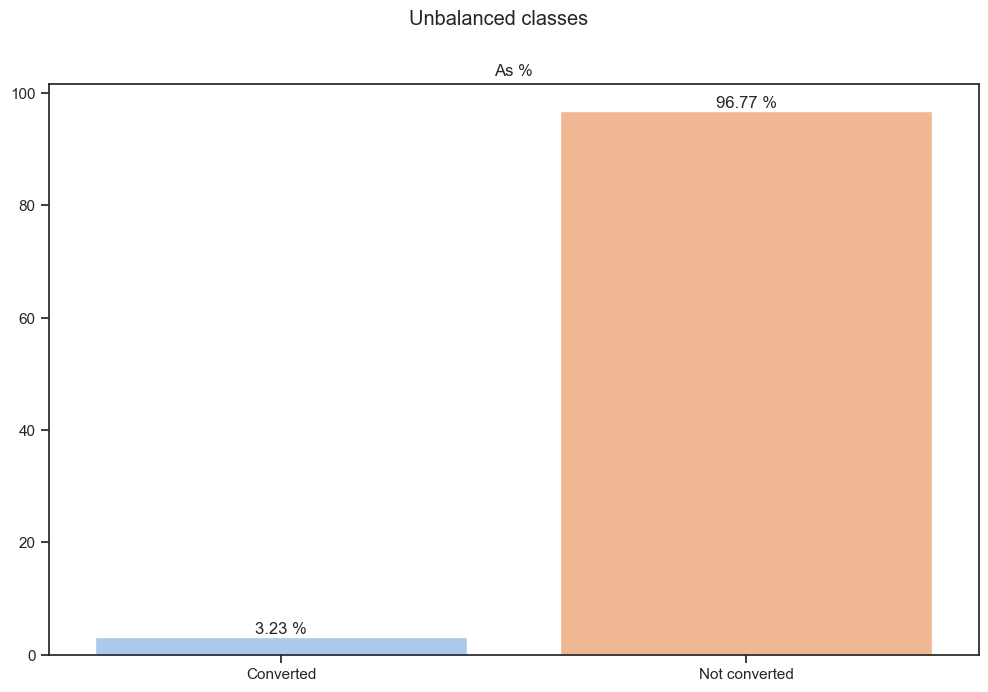

In [49]:
categories  = ['Converted', 'Not converted']
valeurs     = [percent_converted, 100 - percent_converted]

fig, ax = plt.subplots(figsize=(Width,Height))
palette = sns.color_palette("pastel")

sns.barplot (x=categories, y=valeurs, hue = categories, palette=palette)                 
fig.suptitle("Unbalanced classes")
ax.set_title("As %")
# fig.savefig('unbalanced_classes.png')
for i, valeur in enumerate(valeurs):
    ax.text(i, valeur, str(valeur)+" %", ha='center', va='bottom')

### Comments : 

* Clearly the target is imblanced between converted and not converted.
* Let's make sure to use ``stratify`` while searching for the model
* Some good candidate could be : 
    * XGBoost (see the scale_pos_weight hyper parameter), 
    * Random Forest, 
    * AdaBoost 
    * and, why not, using sur oversampling method (SMOTE)

In [50]:
print(df.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB
None 



In [51]:
print(f"Number of null values :")
print()
print(100 * df.isnull().sum() / df.shape[0])
# print (df.isnull().any().any())

Number of null values :

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64


In [52]:
print(f"Lines duplicated : {df.duplicated().sum():>6_}")
percent_duplicated = (100*df.duplicated().sum()/len(df)).round(2)
print(f"As %             :  {percent_duplicated:>9_}%")

Lines duplicated : 268_769
As %             :      94.44%


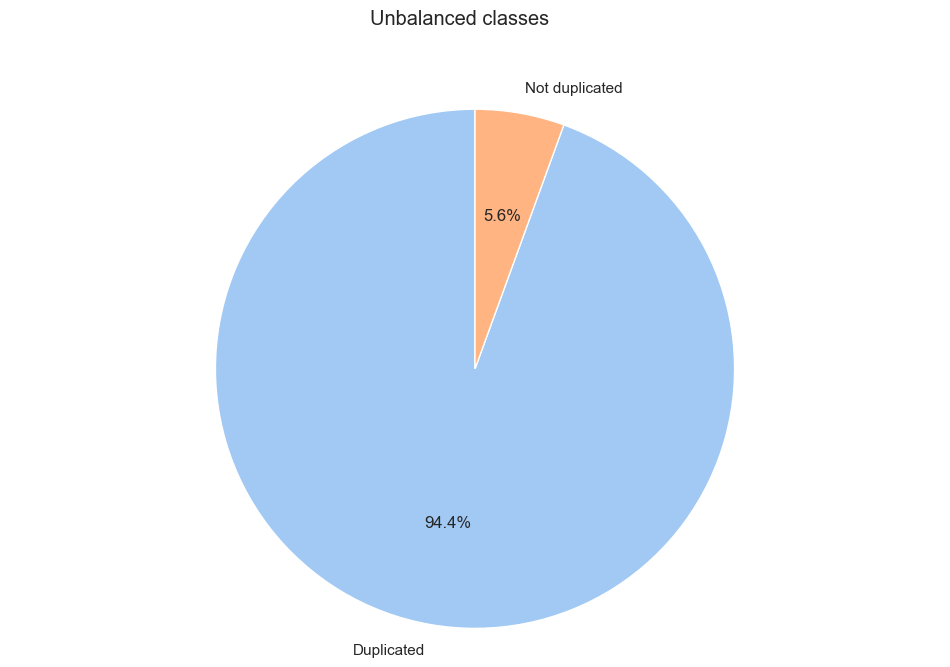

In [53]:
categories  = ['Duplicated', 'Not duplicated']
valeurs     = [percent_duplicated, 100 - percent_duplicated]

fig, ax = plt.subplots(figsize=(Width, Height))
palette = sns.color_palette("pastel")
ax.pie(valeurs, labels=categories, autopct='%1.1f%%', startangle=90, colors=palette)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig.suptitle("Unbalanced classes")
plt.show()

In [54]:
print("Col duplicated   : ", df.columns.duplicated() )

print()

print("Unique countries : ", df["country"].unique())
print("Unique sources   : ", df["source"].unique())


Col duplicated   :  [False False False False False False]

Unique countries :  ['China' 'UK' 'Germany' 'US']
Unique sources   :  ['Direct' 'Ads' 'Seo']


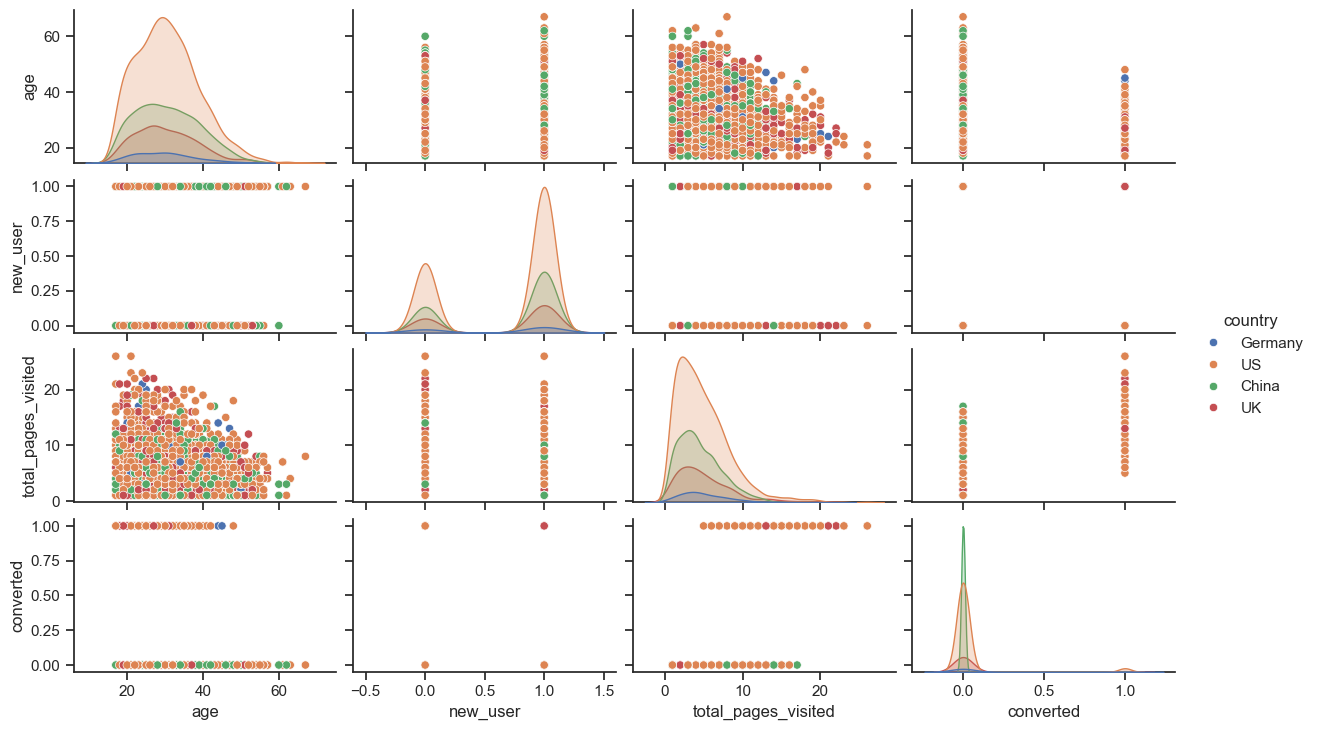

In [39]:
sns.set(style="ticks")
_ = sns.pairplot(df.sample(5_000), hue="country", height=Height/4, aspect=Gold) # , height=Height, aspect=2

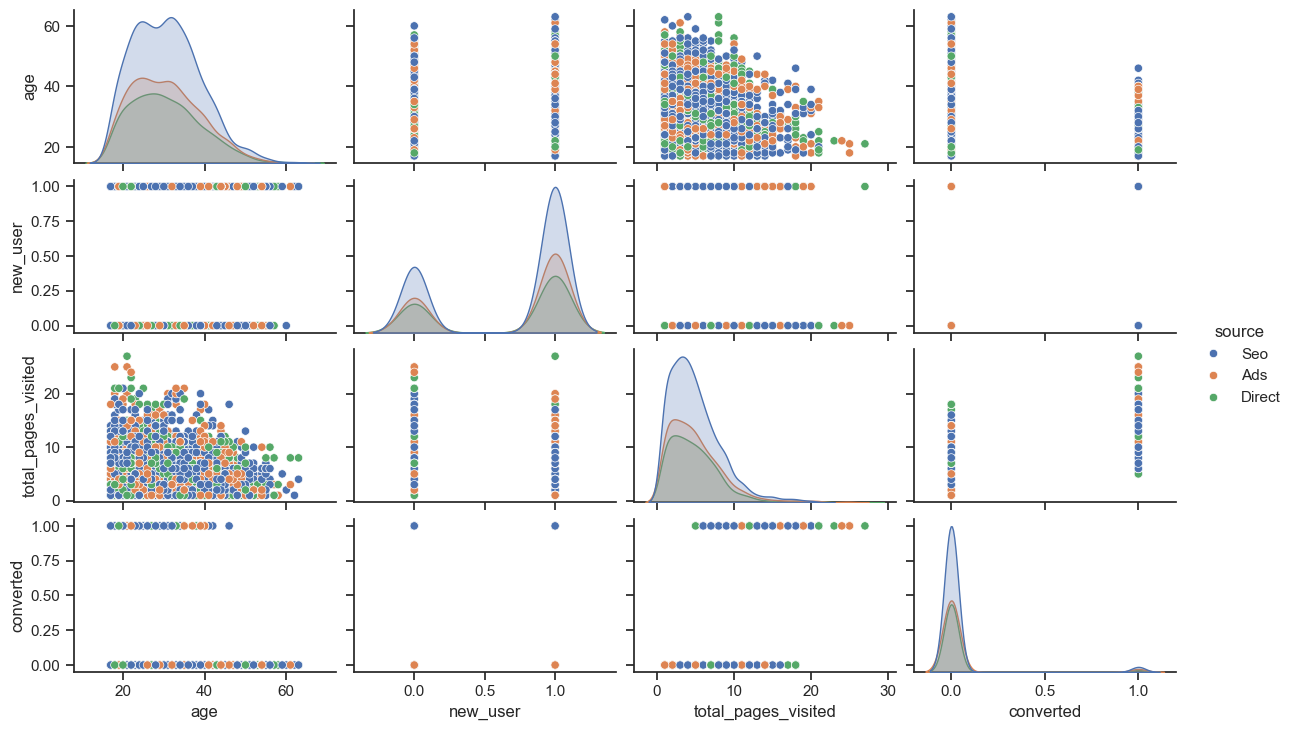

In [41]:
sns.set(style="ticks")
_ = sns.pairplot(df.sample(5_000), hue="source", height=Height/4, aspect=Gold)

### Comments : 
* ``total_pages_visited`` and ``age`` are skewed on the right
* => If we remove outliers, we will use 1.5 * IQR and not the 3 x $\sigma $

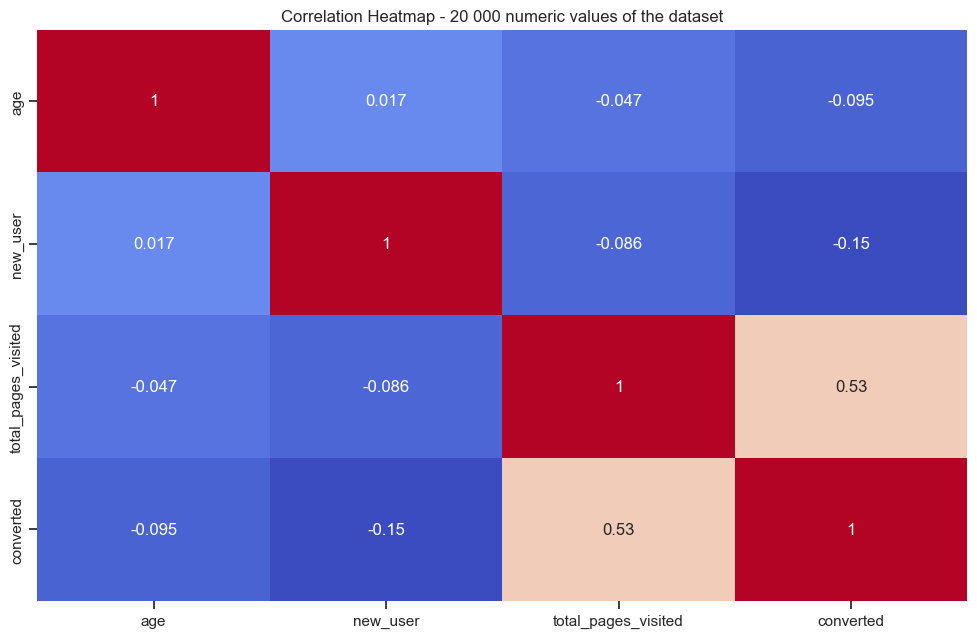

In [56]:
correlation_matrix = df.sample(20_000).corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(Width, Height))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=False)
ax.set_title("Correlation Heatmap - 20 000 numeric values of the dataset");


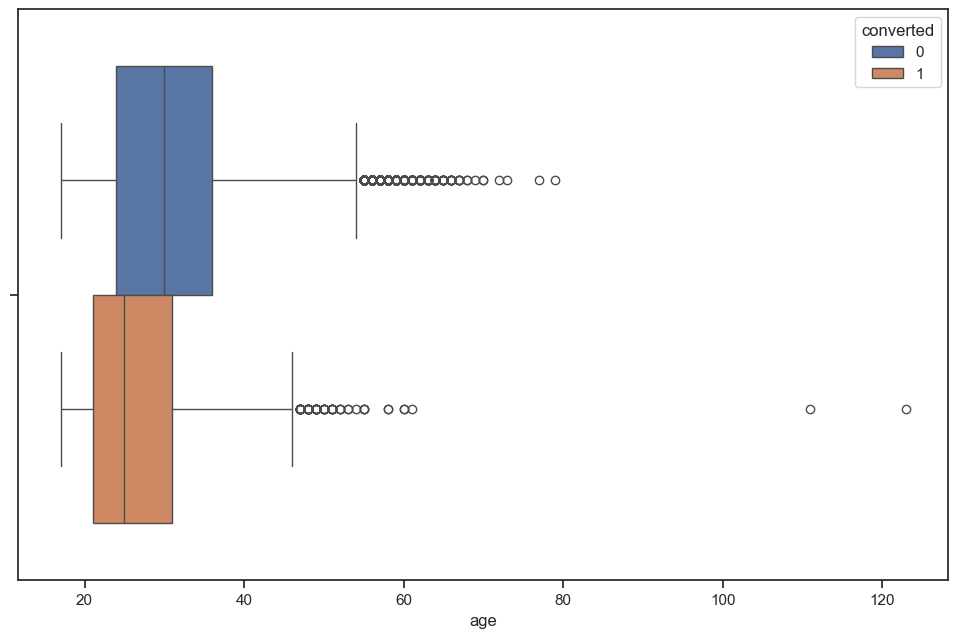

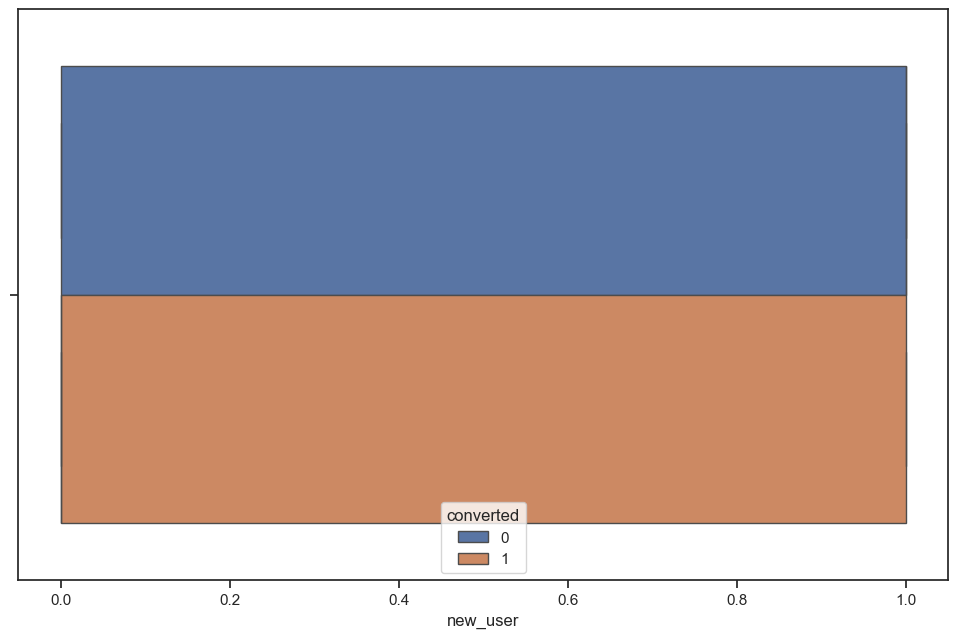

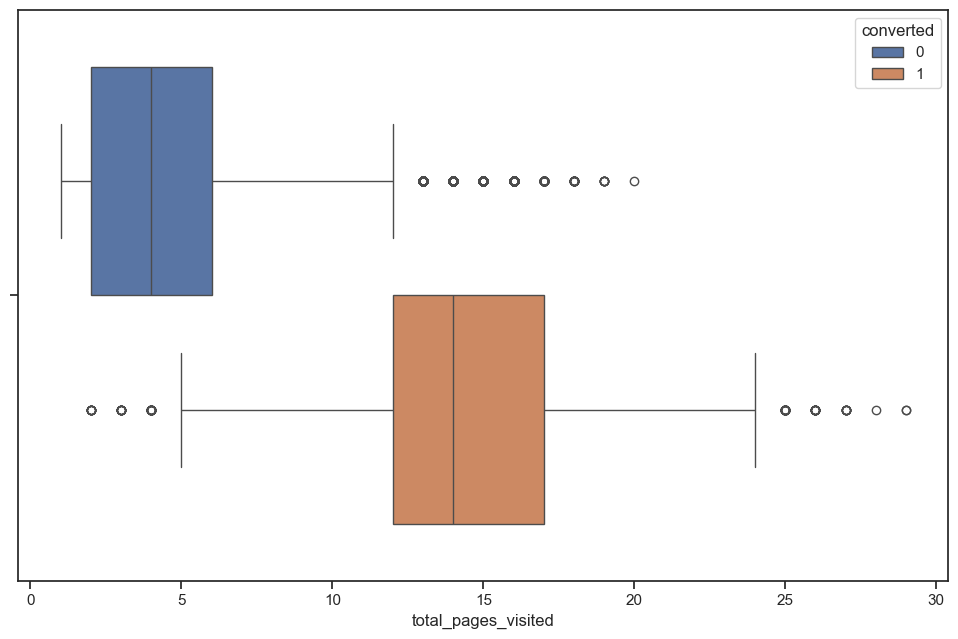

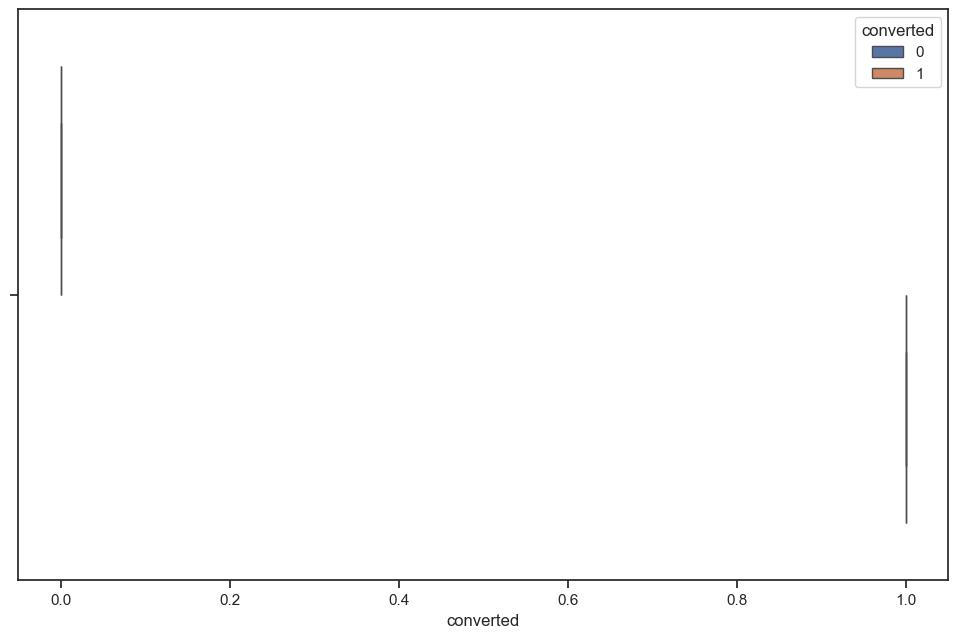

In [43]:
num_feat = df.select_dtypes(include="number").columns
for i, col in enumerate(num_feat):
  fig, ax = plt.subplots(figsize=(Width,Height))
  sns.boxplot(data=df, x=col, hue="converted")
plt.show()


## Pre-preprocessing

In [43]:
# utils function.
# print the name of the dataframe passed in a dict

def print_dict(dataframes_dict): 
  
  for df_name in dataframes_dict:
    df_actual = dataframes_dict.get(df_name)
    print(f"Shape of {df_name} : {df_actual.shape}")            if k_verbose == True else None


In [44]:
# print(df.shape)

numeric_columns = df[["age", "total_pages_visited"]]
# print(type(numeric_columns))
# numeric_columns = ["age	new_user", "total_pages_visited"]

# 1. Calculez l'IQR pour chaque colonne numérique
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# 2. Calculez les limites supérieure et inférieure
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Créez un masque pour identifier les lignes avec des valeurs aberrantes dans les colonnes numériques
outliers_mask = ((numeric_columns < lower_bound) | (numeric_columns > upper_bound)).any(axis=1)

# Filtrez les lignes avec des valeurs aberrantes uniquement dans les colonnes numériques
df = df[~outliers_mask]
# print(df.shape)
# df.head()

In [45]:
X = df.drop(columns=k_target)
y = df[k_target]


In [46]:
if k_verbose : 
  print("X :")
  print(X.head())
  print(X.shape)
  print()

  print("y :")
  print(y.head())
  

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3
(278101, 5)

y :
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64


In [47]:
X_train_back, X_final_test, y_train_back, y_final_test = train_test_split(X, y, test_size=k_final_test_size, random_state=k_random_state, stratify = y)

dataframes_dict = {'Xtrain_back': X_train_back, 'X_final_test': X_final_test, 'y_train': y_train_back, 'y_final_test': y_final_test}
print_dict(dataframes_dict)

# Option to save csv for additional testing on colab
# df_tmp = pd.concat([y, X], axis=1)
# df_tmp.to_csv("./assets/4test_colab.csv", index=False)



Shape of Xtrain_back : (222480, 5)
Shape of X_final_test : (55621, 5)
Shape of y_train : (222480,)
Shape of y_final_test : (55621,)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_train_back, y_train_back, test_size=k_test_size, random_state=k_random_state, stratify = y_train_back)

dataframes_dict = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
print_dict(dataframes_dict)



Shape of X_train : (177984, 5)
Shape of X_test : (44496, 5)
Shape of y_train : (177984,)
Shape of y_test : (44496,)


In [49]:
# # Removing outliers

# # Calculate the upper and lower limits
# def drop_outliers(df, col):
#   Q1 = df[col].quantile(0.25)
#   Q3 = df[col].quantile(0.75)

#   IQR = Q3 - Q1

#   lower = Q1 - 1.5*IQR
#   upper = Q3 + 1.5*IQR

#   upper_array = np.where(df[col]>=upper)[0]
#   lower_array = np.where(df[col]<=lower)[0]
  
#   df.drop(index=upper_array, inplace=True)
#   df.drop(index=lower_array, inplace=True)

In [50]:
# # TODO : see how to transform this code as a pre processing step
# # TODO : find a way to link as in a receipt differents step in pre processing (what about seleciotb etc.)

# Remove duplicates
# df_tmp = df_tmp.drop_duplicates()

def pre_preprocessing2(X, y):
  
  df_tmp = pd.concat([y, X], axis=1)

  df_tmp['weight'] = df_tmp.groupby(df_tmp.columns.tolist(), sort=False).transform('size')
  
  # Dangerous ? Here I suppose y is always the first col 
  # See concat above
  X = df_tmp.drop(df_tmp.columns[0], axis=1)
  y = df_tmp.iloc[:,0]

  return X, y


In [51]:
if(k_bPrePrepocessing):
  print(f"shape : {X_train.shape}") if k_verbose == True else None
  print(f"shape : {y_train.shape}") if k_verbose == True else None
  
  X_train, y_train = pre_preprocessing2(X_train, y_train)  

  print(f"shape : {X_train.shape}") if k_verbose == True else None
  print(f"shape : {y_train.shape}") if k_verbose == True else None

  display(X_train.head(2)) if k_verbose == True else None
  

In [52]:
if(k_bPrePrepocessing):
  print(f"shape : {X_test.shape}") if k_verbose == True else None
  print(f"shape : {y_test.shape}") if k_verbose == True else None
  
  X_test, y_test = pre_preprocessing2(X_test, y_test)  

  print(f"shape : {X_test.shape}") if k_verbose == True else None
  print(f"shape : {y_test.shape}") if k_verbose == True else None

  display(X_test.head(2)) if k_verbose == True else None


In [53]:
# We can either use X_train or X_test to list the names of numerical/categorical columns

numeric_features = X_train.select_dtypes(include="number").columns
print(numeric_features) if k_verbose == True else None

categorical_features = X_train.select_dtypes(exclude="number").columns
print(categorical_features) if k_verbose == True else None



Index(['age', 'new_user', 'total_pages_visited'], dtype='object')
Index(['country', 'source'], dtype='object')


In [54]:

# I know, I know, imputer are not need here since there are no missing values BUT... 
# You never know
numeric_transformer = Pipeline(
  steps=[
    # ("imputer_num", SimpleImputer()),
    ("imputer_num", SimpleImputer(strategy="mean")),
    ("scaler_num", StandardScaler()),
  ]
)

categorical_transformer = Pipeline(
  steps=[
      # ("imputer_cat", SimpleImputer(fill_value="missing", strategy="constant")),  
      ("imputer_cat", SimpleImputer(strategy="most_frequent")),  
      ("encoder_cat", OneHotEncoder(drop="first")),                 
      # ("encoder_cat", OneHotEncoder(handle_unknown='ignore', sparse=False)),                 
    ]
  )

preprocessor = ColumnTransformer(
  transformers=[
      ("num", numeric_transformer,     numeric_features),
      ("cat", categorical_transformer, categorical_features),
    ]
  )


In [55]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print(X_train[0:5].round(3))    if k_verbose == True else None

# ! IMPORTANT : because in this script we work with df NOT nd array 
X_train = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
display(X_train.head())         if k_verbose == True else None

X_test = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())

[[ 0.929  0.667  0.47   1.     0.     0.     0.     1.   ]
 [-0.186  0.667 -1.264  0.     0.     1.     0.     1.   ]
 [-0.805  0.667 -0.917  0.     0.     0.     0.     0.   ]
 [-0.929  0.667  0.817  0.     0.     1.     0.     0.   ]
 [-1.672  0.667  1.857  0.     0.     1.     0.     1.   ]]


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.929303,0.667068,0.470005,1.0,0.0,0.0,0.0,1.0
1,-0.185736,0.667068,-1.264205,0.0,0.0,1.0,0.0,1.0
2,-0.805202,0.667068,-0.917363,0.0,0.0,0.0,0.0,0.0
3,-0.929095,0.667068,0.816847,0.0,0.0,1.0,0.0,0.0
4,-1.672454,0.667068,1.857373,0.0,0.0,1.0,0.0,1.0


In [56]:
def apply_feature_engineering(data, strategy='None', **kwargs):

  """
  Applies a feature engineering strategy to the data.      

  Args: 
  - data (DataFrame)  : The DataFrame containing the initial data.     
  - strategy (str)    : The feature engineering strategy to apply.     
  - kwargs            : Parameters specific to the feature engineering strategy.      

  Returns: DataFrame  : The DataFrame containing the transformed data.     
  """


  match strategy:

    case 'None':
      transformed_df = data.copy()
     
    case 'polynomial_features':
      degree = kwargs.get('degree', 2)          # 2 by default
      poly = PolynomialFeatures(degree=degree)
      transformed_data = poly.fit_transform(data)

      original_feature_names = data.columns
      feature_combinations = poly.powers_

      # Generate names for the new features
      feature_names = [""]
      for feature_combination in feature_combinations[1:]:
          new_feature_name = "*".join([f"{orig_feature}^{power}" if power > 1 else orig_feature for orig_feature, power in zip(original_feature_names, feature_combination)])
          feature_names.append(new_feature_name)

      # new df - transformed features and their names
      transformed_df = pd.DataFrame(transformed_data, columns=feature_names)


      # columns = poly.get_feature_names_out(data.columns)
      # transformed_df = pd.DataFrame(transformed_data, columns=columns)

    case 'log_transform':
      features_to_transform = kwargs.get('features_to_transform', [])
      transformed_df = data.copy()
      transformed_df[features_to_transform] = np.log(data[features_to_transform] + 1) # log neperien

    case 'custom_feature_engineering':
      # Design your own pizza here
      # One can use kwargs
      transformed_df = data.copy()
      

    case _:
      raise ValueError("Feature engineering strategy not recognized.")

  return transformed_df

In [57]:
def apply_feature_selection(X_train, y_train, X_test, feature_selection_id='None', **kwargs):

  """
  Applies a feature selection strategy to the data.      

  Args: 
  - X_train, y_train, X_test (DataFrame)  : the dataframe
  - feature_selection_method (str)        : default None. The delection to be applied     
  - kwargs                                : Parameters specific to the feature selection strategy      

  Returns (DataFrame)                     : The DataFrame containing the selected features     
  """

  match feature_selection_id:
      case "None":
        X_train_selected_df = X_train
        X_test_selected_df = X_test
               
      case 'SelectKBest':
        k = kwargs.get('k', 10)                            # 10 by default
        if df.shape[1]<k:
          k = df.shape[1]
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train.columns[selector.get_support()])
        X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_train.columns[selector.get_support()])

      case 'chi2':
        selector = SelectKBest(score_func=chi2)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train.columns[selector.get_support()])
        X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_train.columns[selector.get_support()])

      case 'Baseline':
        features_list = kwargs.get('features_list', [])
        X_train_selected_df = X_train.loc[:, features_list]
        X_test_selected_df = X_test.loc[:, features_list]

      case 'Baseline2':
        features_list = kwargs.get('features_list', [])
        X_train_selected_df = X_train.loc[:, features_list]
        X_test_selected_df = X_test.loc[:, features_list]

      case 'custom_feature_selection':
        # Design your own pizza here
        # One can use kwargs
        X_train_selected_df = X_train
        X_test_selected_df = X_test
      
      case _:
        raise ValueError("Feature selection method not recognized.")

  return X_train_selected_df, X_test_selected_df


In [58]:
def evaluate_model_scores(model, params, X_train, y_train, X_test, y_test):

  grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='f1', n_jobs=-1)
  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  print(best_params)                        if k_verbose == True else None


  model.set_params(**best_params)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  scores = {
    'accuracy'  : accuracy_score(y_test, y_pred),
    'precision' : precision_score(y_test, y_pred),
    'recall'    : recall_score(y_test, y_pred),
    'f1'        : f1_score(y_test, y_pred)
  }

  return scores


In [59]:
# A dataframe to store the results
results_df = pd.DataFrame(columns=["Pre_processing", 'Feature_Engineering', 'Feature_Selection', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1'])



# Features Engineering Strategies

In [60]:
# Strategies for feature engineering
# At least one strategy MUST be active
# fes stands for features engineering strategies
# One fes = fes id + fes function
# You can define as many selection id as you like
# Make sure to define a set of parameters (even if there is no parameters) for each selection id
feature_engineering_strategies = [
  ('None'           , "None"),
  # ("Poly Feat"      , "polynomial_features"),       # degree
  # ("Log Transform"  , "log_transform"),             # features_to_transform
]

# Define paramter for each strategy
# You can let them uncommented
engineering_params_sets = {
  'None'            : {},
  'Poly Feat'       : {'degree':2},                         
  'Log Transform'   : {'features_to_transform': [0, 1, 2]}, # ! NOT TESTED!!!!!!!!!!!!!! 
}


# Features Selection Strategies

In [61]:

# TODO : simply. Indeed, only tje selection_id is needed
# Strategies for feature selection
# At least one strategy id MUST be active
# You can define as many selection id as you like
# Make sure to define a set of parameters (even if there is no parameter) for each selection id
feature_selection_strategies = [
  ('None'),
  #('Baseline'),
  #('Baseline2'),
  # ('SelectKBest_2'), 
  # ("SelectKBest_1") , 
  # ('chi2'),                            # !!! PAS TESTE
]

# Define paraameters for each strategy
# You can let them uncommented
selection_params_sets = {
  'None'          : {},
  'Baseline'      : {'features_list' : ['num__total_pages_visited'] }, # pay attention to the num__ (double underscore)
  'Baseline2'     : {'features_list' : ['num__total_pages_visited', 'num__age'] }, 
  'SelectKBest_1' : {'k':1},                         
  'SelectKBest_2' : {'k':2},                         
  'chi2'          : {}, 
}


# Models & Hyperparameters

In [62]:
# A model = a model id and a model function
# You can define as many model id as you like
# Make sure to define a set of parameters (even if there is no parameters) for each model id

models = [
    # ("LogisticRegression_3", LogisticRegression()),
    #("LogisticRegression_0", LogisticRegression()),
    #("RandomForestClassifier_0", RandomForestClassifier()),

    # ("LogisticRegression_1", LogisticRegression()),
    # ("LogisticRegression_2", LogisticRegression()),
    # ('Random Forest', RandomForestClassifier()),
    ('XGBoost', XGBClassifier()),
    # ("Gradient Boost Clf", GradientBoostingClassifier())
    # ('SVM', SVC()),
    # ('KNN', KNeighborsClassifier()),
    # ('Logistic Regression', LogisticRegression())
]

# Set of hyperparameters for each model_id
models_params_sets = {
    'RandomForestClassifier_0'  : {"n_estimators" : [200], "max_depth":[20], "min_samples_split":[20], "min_samples_leaf":[4], "max_features":["sqrt"], "random_state":[42]},
    'LogisticRegression_0'      : {},          # baseline model
    'LogisticRegression_1'      : {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
    'LogisticRegression_2'      : {'C': [100], 'max_iter': [1000], 'random_state': [k_random_state]},
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
    'LogisticRegression_3'      : {'penalty' : ['l2', 'None'], 'C': [0.01, 0.1, 1, 10], 'class_weight' : ['None', 'dic', 'balanced'], 'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'random_state': [k_random_state]},
    'LogisticRegression_3'      : {'C' : [0.75 + i * 0.05 for i in range(20)], 'solver' : ['lbfgs', "saga", "newton-cholesky", 'newton-cg', 'sag']},       # 'random_state': [k_random_state]},
    'Random Forest'             : {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
    'SVM'                       : {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNN'                       : {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'XGBoost'                   : {'booster':['gbtree']},
    # https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
    "Gradient Boost Clf"        : {'learning_rate' : [0.1, 0.01], 'n_estimators': [100, 200], 'subsample' : [1.0, 0.8]},
}



In [63]:
results_lst=[]

# fes = Feature Engineering Strategy
for fes_id, fes_fn in feature_engineering_strategies:
  
  display(X_train.head(5))                        if k_verbose == True else None
  print("X_train            : ", type(X_train))   if k_verbose == True else None

  # Loop over feature engineering
  X_train_engineered = apply_feature_engineering(X_train, fes_fn, **engineering_params_sets[fes_id])
  X_test_engineered  = apply_feature_engineering(X_test,  fes_fn, **engineering_params_sets[fes_id])
  # DataFrame
  display(X_train_engineered.head(5))                       if k_verbose == True else None
  print("X_train_engineered : ", type(X_train_engineered))  if k_verbose == True else None

  # Loop over features selection
  for selection_id in feature_selection_strategies:
    X_train_selected, X_test_selected = apply_feature_selection(X_train_engineered, y_train, X_test_engineered, selection_id, **selection_params_sets[selection_id])
    # DataFrame
    display(X_train_selected.head(5))                       if k_verbose == True else None
    print("X_train_selected   : ", type(X_train_selected))  if k_verbose == True else None
    
    # Loop over models
    for model_id, model_fn in models:
      print(f"{fes_id}-{selection_id}-{model_id} : ")
      scores = evaluate_model_scores(model_fn, models_params_sets[model_id], X_train_selected, y_train, X_test_selected, y_test)
      
      results_lst.append(
        {
          'Pre_processing'      : k_bPrePrepocessing,
          'Feature_Engineering' : fes_id,
          'Feature_Selection'   : selection_id,
          'Model'               : model_id,
          'Accuracy'            : scores['accuracy'],
          'Precision'           : scores['precision'],
          'Recall'              : scores['recall'],
          'F1'                  : scores['f1']
        }
      )

results_df = pd.concat([pd.DataFrame([result]) for result in results_lst], ignore_index=True)
print("Scores on test set, ordered by F1 descending : ")
display(results_df.sort_values(by="F1", ascending=False))

# Save the results of the benchmark in a csv file
trailer = datetime.now().strftime("%Y%m%d_%H%M%S")
out_file = "./assets/" + k_result_file + "-" + trailer + ".csv"
results_df.to_csv(out_file, encoding="utf8")


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.929303,0.667068,0.470005,1.0,0.0,0.0,0.0,1.0
1,-0.185736,0.667068,-1.264205,0.0,0.0,1.0,0.0,1.0
2,-0.805202,0.667068,-0.917363,0.0,0.0,0.0,0.0,0.0
3,-0.929095,0.667068,0.816847,0.0,0.0,1.0,0.0,0.0
4,-1.672454,0.667068,1.857373,0.0,0.0,1.0,0.0,1.0


X_train            :  <class 'pandas.core.frame.DataFrame'>


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.929303,0.667068,0.470005,1.0,0.0,0.0,0.0,1.0
1,-0.185736,0.667068,-1.264205,0.0,0.0,1.0,0.0,1.0
2,-0.805202,0.667068,-0.917363,0.0,0.0,0.0,0.0,0.0
3,-0.929095,0.667068,0.816847,0.0,0.0,1.0,0.0,0.0
4,-1.672454,0.667068,1.857373,0.0,0.0,1.0,0.0,1.0


X_train_engineered :  <class 'pandas.core.frame.DataFrame'>


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.929303,0.667068,0.470005,1.0,0.0,0.0,0.0,1.0
1,-0.185736,0.667068,-1.264205,0.0,0.0,1.0,0.0,1.0
2,-0.805202,0.667068,-0.917363,0.0,0.0,0.0,0.0,0.0
3,-0.929095,0.667068,0.816847,0.0,0.0,1.0,0.0,0.0
4,-1.672454,0.667068,1.857373,0.0,0.0,1.0,0.0,1.0


X_train_selected   :  <class 'pandas.core.frame.DataFrame'>
None-None-XGBoost : 
{'booster': 'gbtree'}
Scores on test set, ordered by F1 descending : 


,Pre_processing,Feature_Engineering,Feature_Selection,Model,Accuracy,Precision,Recall,F1
0,False,None,None,XGBoost,0.987482,0.703196,0.419048,0.525149


### <span style="color:orange"><b>RESULTS : Benchmarks on Test Set</b></span>

## Training on the whole dataset 
* DOES NOT INCLUDE X_final_test nor y_final_test 
* No division between train and test set
* The idea is to leverage the maximum of observations to adjest model's parameters

In [64]:
# X = df.drop(columns = k_target)
# y = df[k_target]

# display(X.head(2))  if k_verbose == True else None
# print(X.shape)      if k_verbose == True else None
# print(type(X))      if k_verbose == True else None



In [65]:
# We use X_train_back and y_train_back
# see begining of the code

# we copy X_train_back and y_train_back
# to act as if we were working on the whole dataset

X = X_train_back.copy()
y = y_train_back.copy()

print(f"Shape of X : {X.shape}") if k_verbose == True else None
print(f"Shape of y : {y.shape}") if k_verbose == True else None



Shape of X : (222480, 5)
Shape of y : (222480,)


In [66]:
if(k_bPrePrepocessing):
  print(f"shape : {X.shape}") if k_verbose == True else None
  print(f"shape : {y.shape}") if k_verbose == True else None
  
  X, y = pre_preprocessing2(X, y)  

  print(f"shape : {X.shape}") if k_verbose == True else None
  print(f"shape : {y.shape}") if k_verbose == True else None

  display(X.head(2)) if k_verbose == True else None


In [67]:
X = preprocessor.fit_transform(X)
print(X[0:5].round(3))  if k_verbose == True else None

# ! IMPORTANT because is this code we "play" with df NOT nd arrays
X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())
display(X_train.head()) if k_verbose == True else None

print(X.shape)          if k_verbose == True else None
print(type(X))          if k_verbose == True else None


[[-0.31   0.667 -1.264  0.     1.     0.     0.     0.   ]
 [ 1.425 -1.498 -0.223  0.     0.     0.     0.     1.   ]
 [-0.806  0.667  2.552  0.     0.     1.     0.     0.   ]
 [ 0.682 -1.498 -0.917  0.     0.     1.     0.     0.   ]
 [-1.549  0.667 -0.57   0.     0.     0.     0.     0.   ]]


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.929303,0.667068,0.470005,1.0,0.0,0.0,0.0,1.0
1,-0.185736,0.667068,-1.264205,0.0,0.0,1.0,0.0,1.0
2,-0.805202,0.667068,-0.917363,0.0,0.0,0.0,0.0,0.0
3,-0.929095,0.667068,0.816847,0.0,0.0,1.0,0.0,0.0
4,-1.672454,0.667068,1.857373,0.0,0.0,1.0,0.0,1.0


(222480, 8)
<class 'pandas.core.frame.DataFrame'>


In [68]:
# Retreive the settings of the best classifier
# fes       = feature engineering strategy
# fs        = feature selection
# model_id  = model id

id  = results_df['F1'].idxmax()

fes_id = results_df.at[id, "Feature_Engineering"]
for fes_current_id, fes_current_fn in feature_engineering_strategies:
    if  fes_id == fes_current_id:
        fes_fn = fes_current_fn
        break

fs_id  = results_df.at[id, "Feature_Selection"]
# for fs_current_id in feature_selection_strategies:
#     if  fs_id == fs_current_id:
#         fs_fn = fs_current_fn
#         break

model_id = results_df.at[id, "Model"]
for model_current_id, model_current_fn in models:
    if  model_id == model_current_id:
        model_fn = model_current_fn
        break

# Now we got the parameters. We go through the whole process again
X_engineered  = apply_feature_engineering(X, fes_fn, **engineering_params_sets[fes_id])
print(type(X_engineered))   if k_verbose == True else None

X_selected, _ = apply_feature_selection(X_engineered, y, X_engineered, fs_id, **selection_params_sets[fs_id])
print(type(X_selected))     if k_verbose == True else None

# We call explictily GridSearchCV from here because we need to access to best_params_ 
grid_search = GridSearchCV(model_fn, models_params_sets[model_id], cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_selected, y)


# TODO make a test. We should be able to remove those line
# TODO I suspect the model keep the best params

best_params = grid_search.best_params_
model_fn.set_params(**best_params)

print(X_selected.columns)   if k_verbose == True else None

model_fn.fit(X_selected, y) 

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Index(['num__age', 'num__new_user', 'num__total_pages_visited',
       'cat__country_Germany', 'cat__country_UK', 'cat__country_US',
       'cat__source_Direct', 'cat__source_Seo'],
      dtype='object')


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [69]:
y_pred = model_fn.predict(X)
print(y_pred)                 if k_verbose == True else None


[0 0 0 ... 0 0 0]


In [70]:
print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y,  y_pred):.6f} \t {precision_score(y,  y_pred):.6f} \t {recall_score(y,  y_pred):.6f}")

f1 		 precision 	 recall
0.538501 	 0.733458 	 0.425422


### <span style="color:orange"><b>RESULTS : Best model on Whole Dataset</b></span>

## Predictions on the unseen dataset

In [71]:
if(k_bPrePrepocessing):
  print(f"shape : {X_final_test.shape}") if k_verbose == True else None
  print(f"shape : {y_final_test.shape}") if k_verbose == True else None
  
  X_final_test, y_final_test = pre_preprocessing2(X_final_test, y_final_test)  

  print(f"shape : {X_final_test.shape}") if k_verbose == True else None
  print(f"shape : {y_final_test.shape}") if k_verbose == True else None

  display(X_final_test.head(2)) if k_verbose == True else None


In [72]:
X_final_test = preprocessor.fit_transform(X_final_test)
print(X_final_test[0:5].round(3))  if k_verbose == True else None

# ! IMPORTANT because is this code we "play" with df NOT nd arrays
X_final_test = pd.DataFrame(X_final_test, columns=preprocessor.get_feature_names_out())
display(X_final_test.head())       if k_verbose == True else None

print(X_final_test.shape)          if k_verbose == True else None
print(type(X_final_test))          if k_verbose == True else None


[[ 0.065 -1.492 -0.92   0.     0.     1.     0.     0.   ]
 [-0.928  0.67  -0.92   0.     0.     1.     0.     0.   ]
 [ 1.679 -1.492 -0.571  0.     0.     1.     0.     1.   ]
 [ 0.314  0.67   1.873  0.     0.     0.     1.     0.   ]
 [ 0.065 -1.492 -0.571  0.     0.     0.     1.     0.   ]]


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.065499,-1.492197,-0.920409,0.0,0.0,1.0,0.0,0.0
1,-0.927614,0.670153,-0.920409,0.0,0.0,1.0,0.0,0.0
2,1.679308,-1.492197,-0.571276,0.0,0.0,1.0,0.0,1.0
3,0.313777,0.670153,1.872656,0.0,0.0,0.0,1.0,0.0
4,0.065499,-1.492197,-0.571276,0.0,0.0,0.0,1.0,0.0


(55621, 8)
<class 'pandas.core.frame.DataFrame'>


In [73]:
y_final_pred = model_fn.predict(X_final_test)
print(y_final_pred)                 if k_verbose == True else None


print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y_final_test,  y_final_pred):.6f} \t {precision_score(y_final_test,  y_final_pred):.6f} \t {recall_score(y_final_test,  y_final_pred):.6f}")


[0 0 0 ... 0 0 0]
f1 		 precision 	 recall
0.492938 	 0.700803 	 0.380174


### <span style="color:orange"><b>RESULTS : Best model on Unknown Data</b></span>

## Predictions on the dataset without label

In [74]:
df_no_labels = pd.read_csv('./assets/conversion_data_test.csv')
print(type(df_no_labels))   if k_verbose == True else None
print(df_no_labels.shape)   if k_verbose == True else None


<class 'pandas.core.frame.DataFrame'>
(31620, 5)


In [75]:
X_no_labels = df_no_labels.copy()

if(k_bPrePrepocessing):
  print(f"shape : {df_no_labels.shape}")          if k_verbose == True else None
  # X_no_labels = pre_preprocessing(df_no_labels) 
  X_no_labels['weight'] = X_no_labels.groupby(X_no_labels.columns.tolist(), sort=False).transform('size')
  print(f"shape : {X_no_labels.shape}")           if k_verbose == True else None
  

print(type(X_no_labels))                          if k_verbose == True else None
display(X_no_labels.head(2))                      if k_verbose == True else None


<class 'pandas.core.frame.DataFrame'>


,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5


In [76]:
X_no_labels = preprocessor.transform(X_no_labels)
print(X_no_labels.shape)            if k_verbose == True else None

# ! IMPORTANT : because in this script we work with df NOT nd array 
X_no_labels = pd.DataFrame(X_no_labels, columns=preprocessor.get_feature_names_out())

print(type(X_no_labels))            if k_verbose == True else None
print(X_no_labels.shape)            if k_verbose == True else None
# print(X_no_labels[0:5,:].round(3))  if k_verbose == True else None

(31620, 8)
<class 'pandas.core.frame.DataFrame'>
(31620, 8)


In [77]:
print(X_no_labels.columns)   if k_verbose == True else None
y_no_labels = model_fn.predict(X_no_labels)

display(y_no_labels)                if k_verbose == True else None
print(y_no_labels.shape)            if k_verbose == True else None


Index(['num__age', 'num__new_user', 'num__total_pages_visited',
       'cat__country_Germany', 'cat__country_UK', 'cat__country_US',
       'cat__source_Direct', 'cat__source_Seo'],
      dtype='object')


array([1, 0, 0, ..., 0, 0, 0])

(31620,)


In [78]:
# https://stackoverflow.com/questions/73345752/linear-regression-predict-error-userwarning-x-does-not-have-valid-feature-na


data = {
  'converted' : model_fn.predict(X_no_labels)
}

y_predictions = pd.DataFrame(columns=['converted'], data = data)

trailer         = datetime.now().strftime("%Y%m%d_%H%M%S")
out_file = "./assets/" + k_header + k_author + "-" + trailer + ".csv"
y_predictions.to_csv(out_file, index=False)

